# **Welcome To the Notebook**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Task 1 - Loading our data**

Installing the pyspark using pip

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f29f7af56155aba1c14885d5cc97c3cbe4ddcc7b7cd16d131aa4b70f3dcb06c7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Importing Modules

In [3]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [4]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [5]:
dataset_path = '/content/drive/MyDrive/code/coursera projects/Machine Learning with PySpark: Customer Churn Analysis/data/dataset.csv'
data = spark.read.csv(path = dataset_path, inferSchema=True,header=True)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [6]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [7]:
data.count(), len(data.columns)

(7043, 21)

### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [8]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

Let's get all the numerical features and store them into a pandas dataframe.

In [9]:
numerical_columns = [name for name,typ in data.dtypes if typ == "double" or typ =="int"]
categotical_columns = [name for name,typ in data.dtypes if typ == "string"]

df_num_pandas = data.select(numerical_columns).toPandas()
df_num_pandas.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [10]:
data.select(numerical_columns).describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7032|
|   mean|32.435751810308105| 64.76169246059922|2283.3004408418697|
| stddev| 25.07522813150339|30.090047097678482| 2266.771361883145|
|    min|                 0|             18.25|              18.8|
|    max|               458|            118.75|            8684.8|
+-------+------------------+------------------+------------------+



Let's create histograms to analyse the distribution of our numerical columns.

<ipython-input-11-eb210f442a5e>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_num_pandas.hist(ax = ax, bins=20)


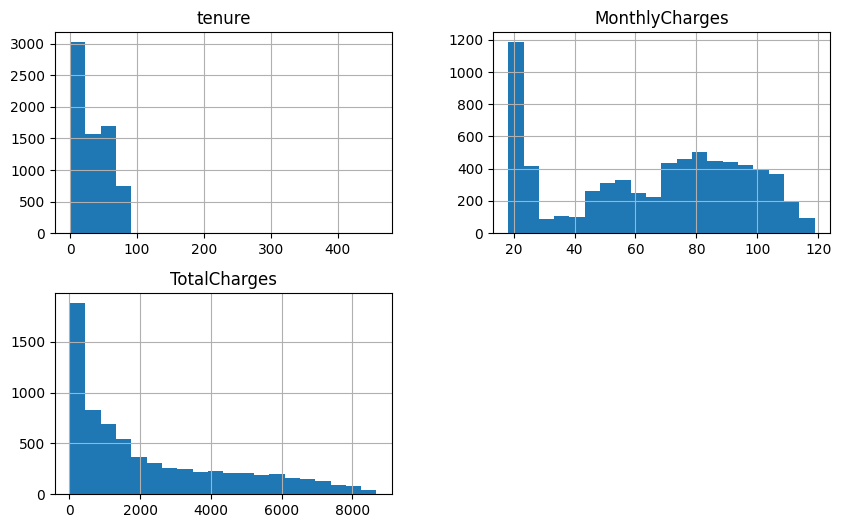

In [11]:
# prompt: Let's create histograms to analyse the distribution of our numerical columns.

fig = plt.figure(figsize=(10,6))
ax = fig.gca()

df_num_pandas.hist(ax = ax, bins=20)

plt.show()


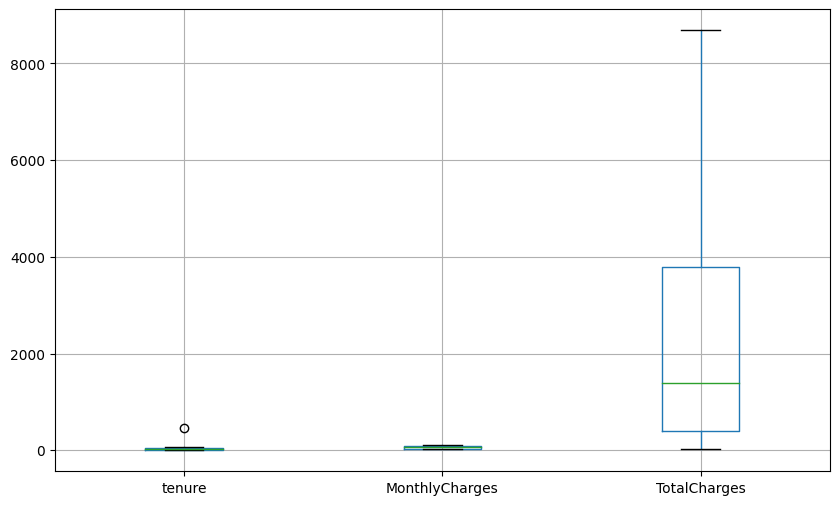

In [12]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

df_num_pandas.boxplot(ax = ax)

plt.show()

outlier in the tenure col

Let's generate the correlation matrix

In [13]:
# convert to vector column first
from pyspark.ml.stat import Correlation

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.select(numerical_columns).columns, outputCol=vector_col,handleInvalid="skip")
df_corr = assembler.transform(data.select(numerical_columns)).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_corr, vector_col)

result = matrix.collect()[0]["pearson({})".format(vector_col)].values
pd.DataFrame(result.reshape(-1, len(data.select(numerical_columns).columns)), columns=data.select(numerical_columns).columns, index=data.select(numerical_columns).columns)


,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.242673,0.806530
MonthlyCharges,0.242673,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check the unique value count per each categorical variables

In [14]:
for co in categotical_columns:
  if co  == 'customerID':
    continue
  data.groupby(co).count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682|
|         Yes| 6361|
+------------+-----+

+----------------+-----+
|   MultipleLines|count|
+----------------+-----+
|No phone service|  682|
|              No| 3390|
|             Yes| 2971|
+----------------+-----+

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|             No| 1526|
|            DSL| 2421|
+---------------+-----+

+-------------------+-----+
|     OnlineSecurity|count|
+-------------------+-----+
|       

Let's find number of null values in all of our dataframe columns

In [15]:
for co in data.columns:
  data.select(count(when(col(co).isNull(), co)).alias(f'{co} null count')).show() # Pass col(co) to the when function

+---------------------+
|customerID null count|
+---------------------+
|                    0|
+---------------------+

+-----------------+
|gender null count|
+-----------------+
|                0|
+-----------------+

+------------------------+
|SeniorCitizen null count|
+------------------------+
|                       0|
+------------------------+

+------------------+
|Partner null count|
+------------------+
|                 0|
+------------------+

+---------------------+
|Dependents null count|
+---------------------+
|                    0|
+---------------------+

+-----------------+
|tenure null count|
+-----------------+
|                0|
+-----------------+

+-----------------------+
|PhoneService null count|
+-----------------------+
|                      0|
+-----------------------+

+------------------------+
|MultipleLines null count|
+------------------------+
|                       0|
+------------------------+

+--------------------------+
|InternetService n

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [16]:
columns_with_missing_values = ['TotalCharges']

Creating our Imputer

In [17]:
imputer = Imputer(inputCols=columns_with_missing_values,outputCols=columns_with_missing_values).setStrategy("mean")

Use Imputer to fill the missing values

In [18]:
imputer = imputer.fit(data)
data = imputer.transform(data)

Let's check the missing value counts again

In [19]:
for co in data.columns:
  data.select(count(when(col(co).isNull(), co)).alias(f'{co} null count')).show()

+---------------------+
|customerID null count|
+---------------------+
|                    0|
+---------------------+

+-----------------+
|gender null count|
+-----------------+
|                0|
+-----------------+

+------------------------+
|SeniorCitizen null count|
+------------------------+
|                       0|
+------------------------+

+------------------+
|Partner null count|
+------------------+
|                 0|
+------------------+

+---------------------+
|Dependents null count|
+---------------------+
|                    0|
+---------------------+

+-----------------+
|tenure null count|
+-----------------+
|                0|
+-----------------+

+-----------------------+
|PhoneService null count|
+-----------------------+
|                      0|
+-----------------------+

+------------------------+
|MultipleLines null count|
+------------------------+
|                       0|
+------------------------+

+--------------------------+
|InternetService n

**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [20]:
data.select("*").where(data.tenure > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [21]:
print("Number of rows:",data.count())
data = data.filter(data.tenure < 100)
print("Number of rows:",data.count())

Number of rows: 7043
Number of rows: 7042


### **Task 4 - Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [22]:
numerical_columns = [name for name,typ in data.dtypes if typ == "double" or typ =="int"] # already defined above


numerical_vector_assembler = VectorAssembler(inputCols = numerical_columns, outputCol='numerical_features_vector')
data = numerical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [23]:
scaler = StandardScaler(inputCol = 'numerical_features_vector', outputCol= 'numerical_features_scaled', withMean=True, withStd=True)
data = scaler.fit(data).transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+
|7590-VHVE

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [24]:
categotical_columns = [name for name,typ in data.dtypes if typ == "string"] # already defined above
categotical_columns_indexed = [co + '_indexed' for co in categotical_columns]
indexer = StringIndexer(inputCols=categotical_columns, outputCols=categotical_columns_indexed)
data  = indexer.fit(data).transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vecto

Let's combine all of our categorifal features in to one feature vector.

In [25]:
categotical_columns_indexed.remove('customerID_indexed')
categotical_columns_indexed.remove('Churn_indexed')

categotical_vector_assembler = VectorAssembler(inputCols = categotical_columns_indexed, outputCol='categotical_features_vector')
data = categotical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Ch

Now let's combine categorical and numerical feature vectors.

In [26]:
final_vector_assembler = VectorAssembler(inputCols = ['numerical_features_scaled','categotical_features_vector'], outputCol='final_feature_vector')
data = final_vector_assembler.transform(data)
data.select(['final_feature_vector','Churn_indexed']).show(5)

+--------------------+-------------+
|final_feature_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,1,2,3,5,7,...|          0.0|
|(19,[0,1,2,9,10,1...|          0.0|
|(19,[0,1,2,9,10,1...|          1.0|
|[0.51406079695460...|          0.0|
|(19,[0,1,2,3],[-1...|          1.0|
+--------------------+-------------+
only showing top 5 rows



### **Task 5 - Model Training**
- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model

In this task, we are going to start training our model

In [27]:
train, test = data.randomSplit([0.7,0.3], seed = 100)
train.count(),test.count()

(4930, 2112)

Now let's create and train our desicion tree

In [28]:
clf_dt = DecisionTreeClassifier(featuresCol='final_feature_vector', labelCol="Churn_indexed") #maxDepth = 3
model = clf_dt.fit(train)

Let's make predictions on our test data

In [29]:
prediction_test = model.transform(test)
prediction_test.select("Churn_indexed", 'prediction').show()

+-------------+----------+
|Churn_indexed|prediction|
+-------------+----------+
|          1.0|       1.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       1.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       1.0|
|          0.0|       1.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 20 rows



### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning

In [31]:
evaluator = BinaryClassificationEvaluator(labelCol= 'Churn_indexed')
auc_test = evaluator.evaluate(prediction_test,{evaluator.metricName: "areaUnderROC"})
auc_test

0.5664944085244075

Let's get the AUC for our `training` set

In [32]:
prediction_train = model.transform(train)
auc_train = evaluator.evaluate(prediction_train,{evaluator.metricName: "areaUnderROC"})
auc_train


0.5647403286677019

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model.

In [34]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [35]:
maxDepths = list(range(1,21))
test_acc,train_acc = evaluate_dt(maxDepths)

Let's visualize our results

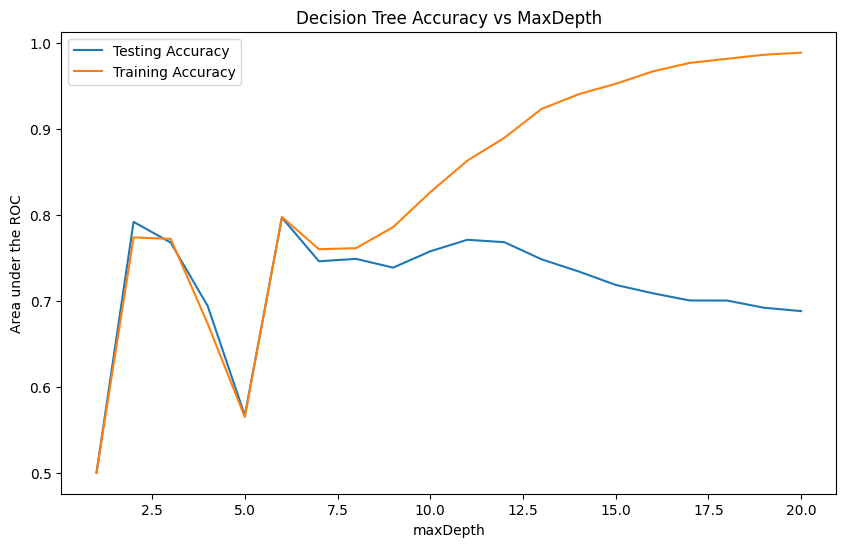

In [36]:
# prompt: Let's visualize our results
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

ax.plot(maxDepths, test_acc, label='Testing Accuracy')
ax.plot(maxDepths, train_acc, label='Training Accuracy')

ax.set_xlabel('maxDepth')
ax.set_ylabel('Area under the ROC')
ax.set_title('Decision Tree Accuracy vs MaxDepth')

plt.legend()
plt.show()


In [38]:
clf_dt = DecisionTreeClassifier(featuresCol='final_feature_vector', labelCol="Churn_indexed", maxDepth = 6)
model = clf_dt.fit(train)

prediction_test = model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol= 'Churn_indexed')
auc_test = evaluator.evaluate(prediction_test,{evaluator.metricName: "areaUnderROC"})
print("Test roc: ",auc_test)

prediction_train = model.transform(train)
auc_train = evaluator.evaluate(prediction_train,{evaluator.metricName: "areaUnderROC"})
auc_train
print("Train roc: ",auc_test)

Test roc:  0.7968193482241807
Train roc:  0.7968193482241807


### **7 - Model Deployment**
- Giving Recommendations using our model



We were asked to recommend a solution to reduce the customer churn.


In [48]:
feature_importance = model.featureImportances
df = pd.DataFrame([score for score in feature_importance], columns = ["score"], index = numerical_columns + categotical_columns_indexed)
px.bar(df)

Let's create a bar chart to visualize the customer churn per contract type

In [50]:
df = data.groupby(["Contract", "Churn"]).count().toPandas()
px.bar(df, x = "Contract", y = "count", color = "Churn")

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts.